Find Gaussian integration rules of arbitrary order. Use that the monic Legendre polynomials are

$$ \tilde L_n(x) = det(xI−A_n) $$

with

$$ A_n= \left(\begin{array}{cc} 
0 & \gamma_1 &&& \\
\gamma_1 & 0 & \gamma_2 && \\
& \gamma_2 & \ddots & \ddots & \\
&   & \ddots & \ddots & \gamma_{n-1} \\
& & & \gamma_{n-1} & 0
\end{array}\right) $$

and

$$ \gamma_j = \frac{1}{\sqrt{4−j^{−2}}}$$

Verify the formulas by plotting Legendre polynomials $L_n(x)$, and $\tilde L_n(x) / \tilde L_n(1)$.

Find roots of  $\tilde L_n(x)$ by computing the eigenvalues of $A_n$. Find  integration  weights  by  solving  a  linear  system  of  equations.   The  integrationrule with $n+1$ points must be exact (at least) for polynomials up to order $n$.  To set up the equation,  use either monomials $x^i$,  or Legendre polynomials.  Test your integration rules as in Ex 15. How far can you go with $n$? You  may  use  libraries  for  finding  eigenvalues  (scipy.linalg.eigh),  solving  linear  systems, computing determinants, and evaluating Legendre polynomials.
nice reading:  https://gubner.ece.wisc.edu/gaussquad.pdf, Example 15

### Idea of Quadrature:
Approximation of the integral of a function $f(x)$ with the integral of a polynomial interpolation:

$$ \int_a^b f(x) dx \approx \int_a^b I_f(x) dx =: Q(f)$$

with the polynomial written w.r.t the Lagrange basis:

$$ I_f(x) = \sum_{j=0}^n f(x_j) l_j(x)$$

$$ \int_a^b I_f(x) dx = \int_a^b \sum_{j=0}^n f(x_j) l_j(x) dx = \sum_{j=0}^n \int_a^b l_j(x) dx f(x_j)$$

with the intergration weight
$$ \omega_j = \int_a^b l_j(x) dx $$
$$ \sum_{j=0}^n \omega_j f(x_j) $$

By always transforming the interval $[a, b]$ to the unit interval $[0, 1]$ the normalized reference wieghts and points can be calculated once and for all.

$$ \int_a^b f(x) dx = \int_0^1 f(a+sh) h  ds$$
with $h$ being the interval length.

Therefore:
$$ \int_a^b f(x) dx \approx h \sum_{j=0}^n \omega_j f(a+c_j h)$$
with $c_j$ and $\omega_j$ being normalized reference weights and points.

For better apprxomation performance the interval $[a, b]$ can be split into $m$ sub intervals.

### Idea of Gaussian Quadrature:

Choose also the integration points in such a way that polynomials of twice the order can be estimated exactly. Choose the roots of the Legendre Polynomials as integration points.



In [90]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy import special

n = 5

j_gamma = np.arange(1, n)
gamma_j = 1 / np.sqrt(4-1/j_gamma**2)

An = np.diagflat(gamma_j, -1) + np.diagflat(gamma_j, 1)

x_plot = np.linspace(-1, 1, 100, endpoint=True)

ln_tilde = np.zeros(x_plot.shape)
for idx, x in enumerate(x_plot):
    ln_tilde[idx] = np.linalg.det(np.identity(n)*x - An)

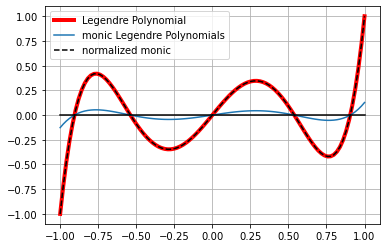

In [62]:
from scipy.special import legendre
Pn = legendre(n)

plt.figure()
plt.plot(x_plot, Pn(x_plot), "-r", linewidth=4, label="Legendre Polynomial")
plt.plot(x_plot, ln_tilde, label="monic Legendre Polynomials")
plt.plot(x_plot, ln_tilde / ln_tilde[-1], '--k', label="normalized monic")
plt.plot([-1, 1], [0, 0], 'k')
plt.grid()
plt.legend()

In [101]:
def get_gaussian_rule(n):
    j_gamma = np.arange(1, n)
    gamma_j = 1 / np.sqrt(4-1/j_gamma**2)

    An = np.diagflat(gamma_j, -1) + np.diagflat(gamma_j, 1) 
    roots, _ = scipy.linalg.eigh(An)
    
    b = np.zeros(n)
    i = np.arange(0, n)
    b[::2] = 2/(i[::2]+1)

    roots = np.reshape(roots, (-1, 1))
    A = np.power(roots, i).T

    w = np.linalg.solve(A, b)
    
    return roots.flatten(), w


def composite_integration(f, a, b, m, quad_rule):
    c_k = np.array([quad_rule[i][0] for i in range(len(quad_rule))])
    w_k = np.array([quad_rule[i][1] for i in range(len(quad_rule))])
    
    h = (b-a)/m
    
    total_integral = 0
    for sub_intervall_idx in range(m):
        x_j = a + sub_intervall_idx * h
        
        f_values = f(x_j + h/2 + c_k*h/2)
        integral_subinterval = h/2 * np.sum(f_values * w_k)
        
        total_integral += integral_subinterval
        
    return total_integral


def fun1(x):
    return np.exp(x)


def fun2(x):
    return np.sqrt(x)

fun1_true_val = np.e - 1
fun2_true_val = 2/3

C:\Users\Markus\.conda\envs\numerical_computing_jupyter\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


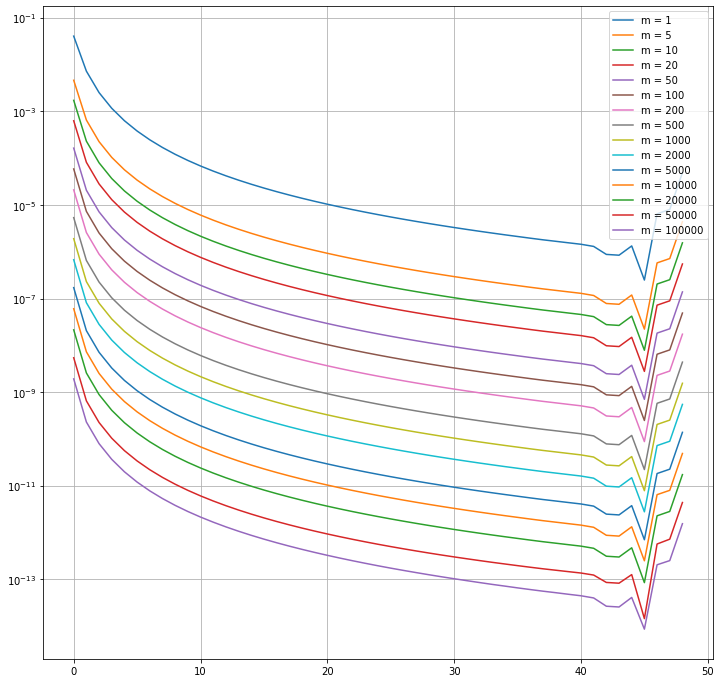

In [137]:
max_n = 100
error_matrix = np.empty((max_n, 1))
error_matrix[:] = np.nan
for n in range(1, max_n+1):
    integration_pts, integration_weights = get_gaussian_rule(n)
    rule = list(zip(integration_pts, integration_weights))
    
    error_matrix[n-1, 0] = np.abs(composite_integration(fun2, 0, 1, 1, rule) - fun2_true_val)
    
m_list = np.array([1, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000])  # np.arange(1, 100, 10)
n_list = np.arange(1, 50)
error_matrix2 = np.empty((max_m, len(n_list)))
error_matrix2[:] = np.nan
for n_idx, n in enumerate(n_list):
    integration_pts, integration_weights = get_gaussian_rule(n)
    rule = list(zip(integration_pts, integration_weights))
    
    for m_idx, m in enumerate(m_list):
        error_matrix2[m_idx, n_idx] = np.abs(composite_integration(fun2, 0, 1, m, rule) - fun2_true_val)
        
plt.figure(figsize=(12, 12))
plt.plot(error_matrix2.T)
plt.yscale("log")
#plt.xscale("log")
plt.grid()
plt.legend(["m = " + str(m_list[i]) for i in range(len(m_list))])